In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [4]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))

In [5]:
df = pd.read_csv('MSFT5.csv')

In [6]:
df.head()

,Date,Date value,Open,High,Low,Close,Adj Close,Volume
0,28-10-2015,42305,53.540001,53.980000,52.860001,53.980000,49.056763,47000800
1,29-10-2015,42306,53.540001,53.830002,53.220001,53.360001,48.493317,30202100
2,30-10-2015,42307,53.320000,53.990002,52.619999,52.639999,47.838978,46619800
3,02-11-2015,42310,52.849998,53.360001,52.619999,53.240002,48.384258,30285000
4,03-11-2015,42311,52.930000,54.389999,52.900002,54.150002,49.211269,36596900


In [7]:
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index=df['Date']

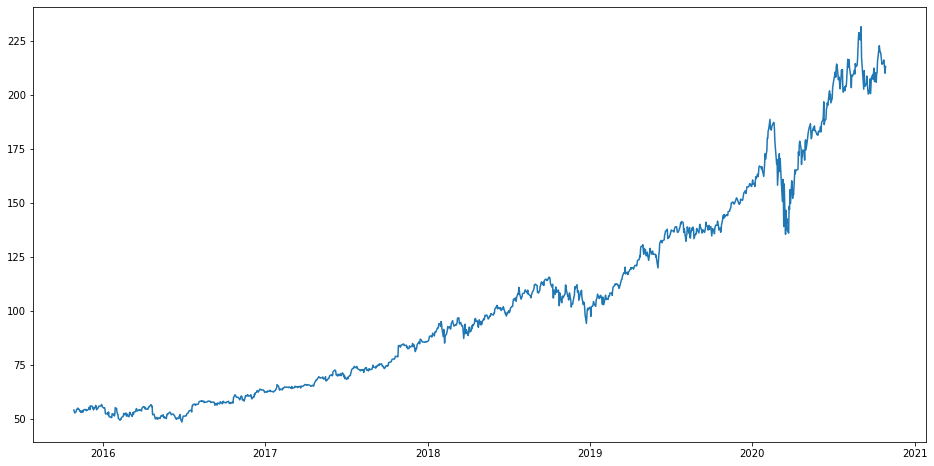

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [9]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]


In [10]:
new_data.head()

,Date,Close
0,2015-10-28 00:00:00,53.98
1,2015-10-29 00:00:00,53.36
2,2015-10-30 00:00:00,52.64
3,2015-11-02 00:00:00,53.24
4,2015-11-03 00:00:00,54.15


In [11]:
df.shape

(1259, 8)

In [12]:
train=new_data[:988]
valid=new_data[988:]

In [13]:
train.shape

(988, 2)

In [16]:
valid.shape

(271, 2)

# Moving Average

In [14]:
pred=[]
for i in range(len(valid)):
    a = train['Close'][len(valid)-271+i:].sum()+sum(pred)
    b=a/271
    pred.append(b)

In [15]:
#Root mean square error
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-pred),2)))
rms

326.3602244145678

<ipython-input-16-aebb20b18303>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-16-aebb20b18303>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred


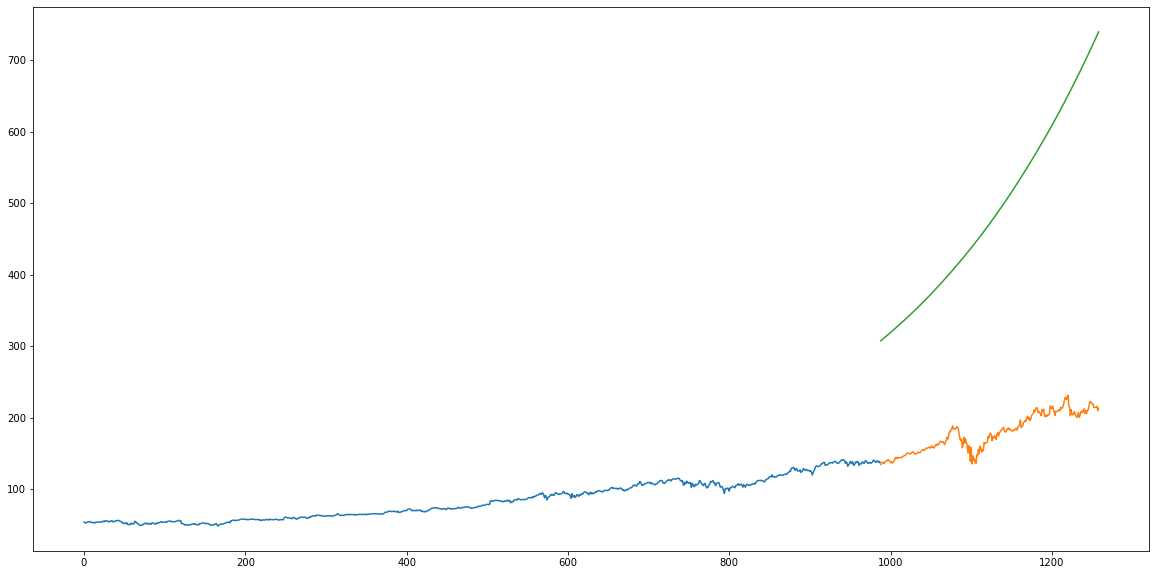

In [16]:
#Predictions from Moving avg 
valid['Predictions'] = 0
valid['Predictions'] = pred
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

# Linear Regression

In [17]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [18]:
#create features
import re
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,53.98,2015,10,44,28,2,301,False,False,False,False,False,False
1,53.36,2015,10,44,29,3,302,False,False,False,False,False,False
2,52.64,2015,10,44,30,4,303,False,False,False,False,False,False
3,53.24,2015,11,45,2,0,306,False,False,False,False,False,False
4,54.15,2015,11,45,3,1,307,False,False,False,False,False,False


In [19]:
new_data[['Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start']]=new_data[['Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start']].astype(int)

In [20]:
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,53.98,2015,10,44,28,2,301,0,0,0,0,0,0
1,53.36,2015,10,44,29,3,302,0,0,0,0,0,0
2,52.64,2015,10,44,30,4,303,0,0,0,0,0,0
3,53.24,2015,11,45,2,0,306,0,0,0,0,0,0
4,54.15,2015,11,45,3,1,307,0,0,0,0,0,0


In [21]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [22]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

41.59203755413283

<ipython-input-23-6bf434f9c655>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-23-6bf434f9c655>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


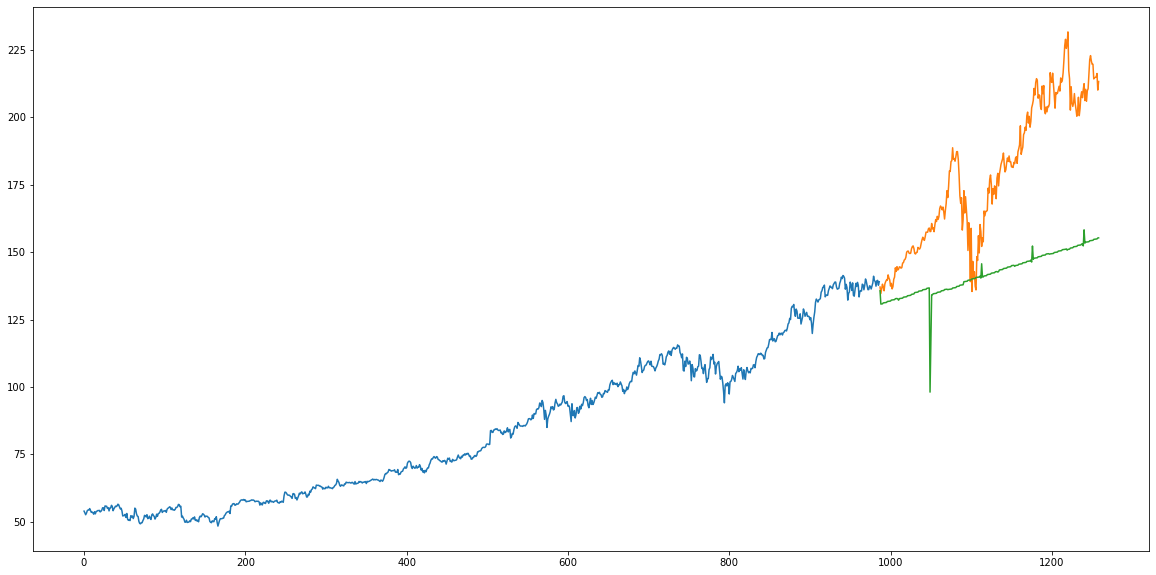

In [23]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[987:].index
train.index = new_data[:987].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

In [24]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [25]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [26]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

71.97665523670354

<ipython-input-27-5857ffdafc4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-27-5857ffdafc4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


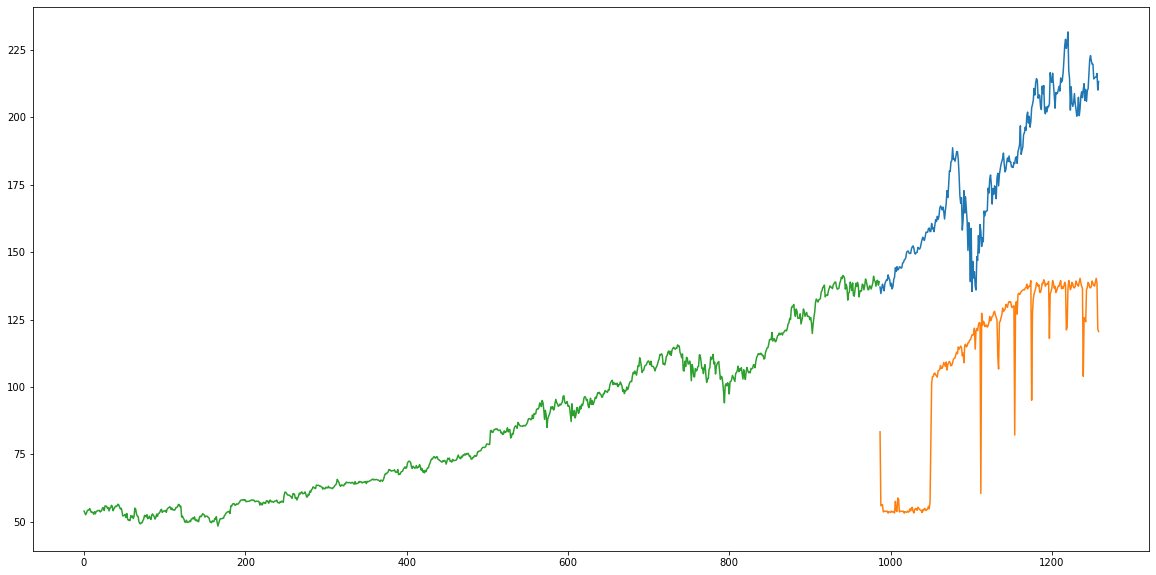

In [27]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

# Auto Arima Model

In [28]:
from pmdarima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=272)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3933.447, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3660.039, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3918.649, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3554.315, Time=1.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.55 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3571.375, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3538.047, Time=1.33 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3641.917, Time=0.64 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.80 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.42 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=3539.234, Time=1.68 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=3538.

In [29]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

38.17056099025026

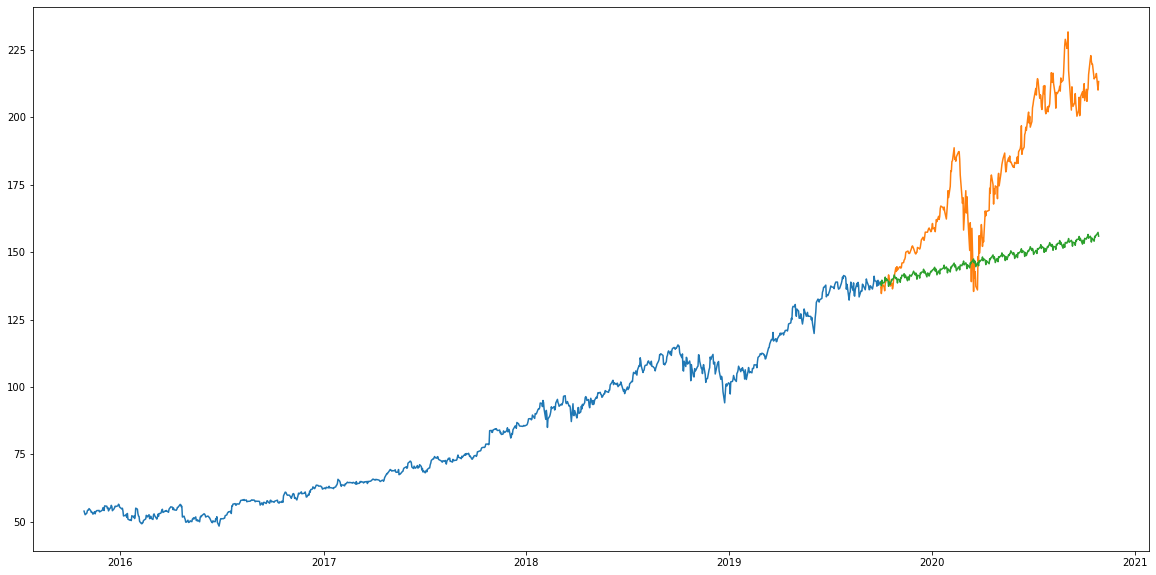

In [30]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])


# LSTM Model 

In [39]:
#importing required libraries

from tensorflow import keras 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


927/927 - 18s - loss: 6.6497e-04


In [37]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

9.818520019509304

<ipython-input-38-8fdd2397322f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


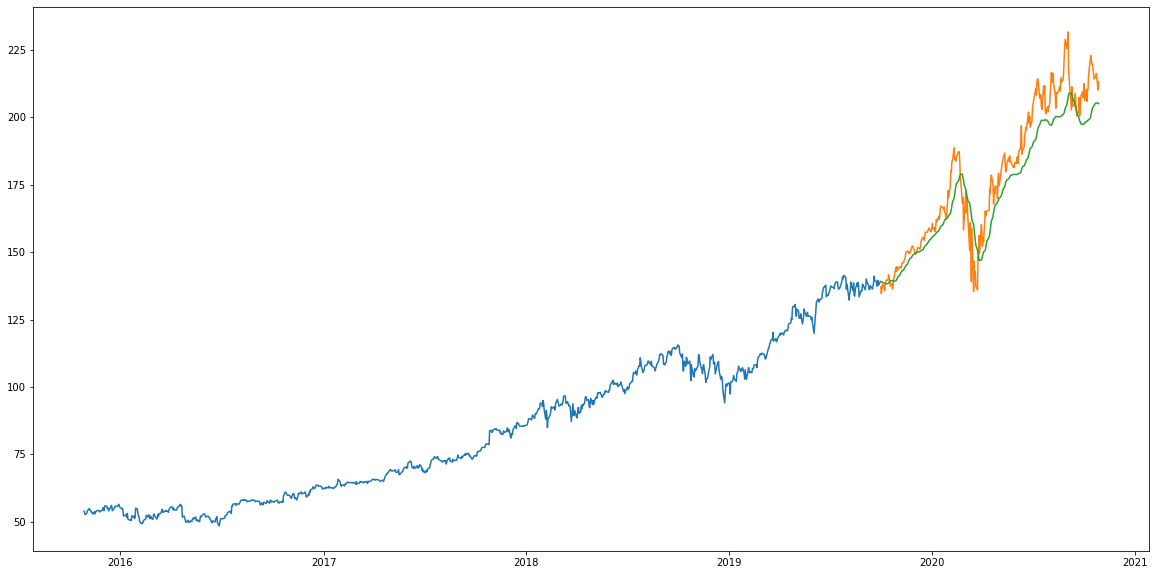

In [38]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])